# Прогноз выживаемости пассажиров на Титанике

## Оглавление
- [Описание проекта](#1)
- [Импорт библиотек и данных](#2)
- [Обзор данных](#3)
- [Подготовка данных](#4)
- [Исследовательский анализ данных](#5)
- [Обучение моделей](#6)
- [Итог](#7)

## <a id='1'>Описание проекта</a>

- [Перейти к следующему блоку](#2)

Источник данных: https://www.kaggle.com/c/titanic/overview

Крушение Титаника - одно из самых печально известных кораблекрушений в истории.

15 апреля 1912 года во время своего первого рейса широко известный «непотопляемый» Титаник затонул после столкновения с айсбергом. К сожалению, на борту не хватило спасательных шлюпок на всех, в результате чего погибли 1502 человека из 2224 пассажиров и членов экипажа.

Хотя в выживании был определенный элемент удачи, похоже, некоторые группы людей выживали с большей вероятностью, чем другие.

В этой задаче мы просим вас построить прогностическую модель, которая отвечает на вопрос: «Какие типы людей выживут с большей вероятностью?» с использованием данных о пассажирах (например, имя, возраст, пол, социально-экономический класс и т. д.).

## <a id='2'>Импорт библиотек и данных</a>

- [Перейти к предыдущему блоку](#1)
- [Перейти к следующему блоку](#3)

Импортируем все необходимые библиотеки. 

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 11, 7
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder

#Модели
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV

Импортируем необходимые для работы файлы. 

In [2]:
train = pd.read_csv('/Users/valeriaastahova/Desktop/Kaggle/Титаник /train.csv')
test = pd.read_csv('/Users/valeriaastahova/Desktop/Kaggle/Титаник /test.csv')
gender_sub = pd.read_csv('/Users/valeriaastahova/Desktop/Kaggle/Титаник /gender_submission.csv') 
# gender_sub - пример формата вывода для загрузки на кеггль

## <a id='3'>Обзор данных</a> 

- [Перейти в начало проекта](#1)
- [Перейти к предыдущему блоку](#2)
- [Перейти к следующему блоку](#4)

Посмотрим информацию о тренировочном датасете.

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


У нас есть следующие столбцы: 
* PassengerId – ID пассажира
* Survived – целевой признак, факт выживания 
* Pclass – класс билета 
* Name – имя - столбец, который, скорее всего, нам не пригодится, потому что никакую зависимость от имени мы выявить не сможем
* Sex – пол 
* Age – возраст 
* SibSp – братья/сестры на борту (?)
* Parch – родители/дети на борту (?)
* Ticket – номер билета - как и имя, это, скорее всего, лишний признак, который не будет нести в себе никакой информации, потому что номера билетов так же уникальны
* Fare – тариф/стоимость (?)
* Cabin – номер каюты - наиболее вероятно, что номер каюты тоже никак напрямую не влияет на выживаемость. При этом в этом столбце очень много пропусков, заполнить которые мы, конечно же, не сможем адекватно.
* Embarked – порт посадки (?) - тоже сомнительный признак, но выводы по нему мы сделаем после рассмотрения матрицы корреляций 


После беглого обзора данных были выявлены следующие проблемы: 
* Названия столбцов написаны разными регистрами, для удобства приведем названия столбцов к нижнему регистру 
* Есть лишние признаки, которые, скорее всего, не могут влиять на факт выживаемости (например, имя пассажира или номер билета)
* Есть пропуски в столбцах с возрастом и номером кабины, а также два пропуска в столбце с портом посадки. Если номер кабины вряд ли пригодится нам для построения модели, то возраст, вероятно, имеет значение
* Столбцы с типом object, которые нужно привести к int или float 
* Столбец Age имеет тип float, нужно привести его к типу int
* Есть категориальные признаки (например, Pclass), которые необходимо закодировать

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Выше видно, что в тестовом датасете у нас тоже есть пропущенные значения и неправильные форматы данных. 

Посмотрим на распределения количественных данных.

In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Единственная странность в этих распределениях – что возраст не является целочисленной переменной. Вероятно, его вычисляли с учетом дополнительных месяцев, но для нас это не имеет значения, поэтому тип данных необходимо будет изменить. 

Также видно, что признаки имеют совершенно разные распределения. Например, у признака Fare очень высокие максимальные значения в сравнении с остальными признаками. Это может негативно сказаться на линейных моделях, потому что они будут присваивать ему бОльшие веса. Если будем использовать линейные модели, необходимо будет нормировать данные. 

Проверим баланс классов в тренировочной выборке.

In [7]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

60/40 – не идеально, но вполне неплохо. 

### Итог обзора данных 
Были выявлены следующие проблемы: 
* Названия столбцов написаны разными регистрами, необходимо все их привести к нижнему регистру 
* Есть лишние признаки, которые, скорее всего, не могут влиять на факт выживаемости (например, имя пассажира или номер билета)
* Есть пропуски в столбцах с возрастом и номером кабины, а также два пропуска в столбце с портом посадки. Если номер кабины вряд ли пригодится нам для построения модели, то возраст, вероятно, имеет значение
* Столбцы с типом object, которые нужно привести к int или float 
* Столбец Age имеет тип float, нужно привести его к типу int

Отдельно после тестового обучения моделей можно попробовать сделать: 
* Есть категориальные признаки (например, Pclass), которые необходимо закодировать
* Нормирование данных (для линейных моделей) 
* Балансировка классов (при необходимости) 

## <a id='4'>Подготовка данных</a>

- [Перейти в начало проекта](#1)
- [Перейти к предыдущему блоку](#3)
- [Перейти к следующему блоку](#5)

По итогам обзора данных нам необходимо: 
* Привести названия столбцов к нижнему регистру 
* Удалить лишние признаки (например, имя пассажира или номер билета)
* Удалить или заполнить пропуски
* Привести к int или float столбцы с типом object
* Привести к типу int столбец Age с типом float

Начнем с приведения названий столбцов к нижнему регистру. 

In [8]:
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Удалим лишние признаки name, ticket, cabin. Предварительно удостоверимся, что уникальных значений в ticket и cabin действительно слишком много, а значит, признаки не являются категориальными и не могут влиять на целевой признак.

In [10]:
train['ticket'].value_counts()

CA. 2343    7
1601        7
347082      7
CA 2144     6
347088      6
           ..
PC 17595    1
PC 17612    1
350034      1
370375      1
14312       1
Name: ticket, Length: 681, dtype: int64

У нас есть 681 уникальное значение в этом столбце. Никакой зависимости здесь быть не может. Мы можем смело удалять этот столбец. Проверим столбец cabin.

In [11]:
train['cabin'].value_counts()

C23 C25 C27    4
B96 B98        4
G6             4
C22 C26        3
E101           3
              ..
A5             1
D10 D12        1
D46            1
D9             1
A16            1
Name: cabin, Length: 147, dtype: int64

Здесь наблюдается та же ситуация. В 204 строках у нас целых 147 уникальных значений. Столбец можно удалять. 

In [12]:
train = train.drop(['name', 'ticket', 'cabin'], axis=1)
test = test.drop(['name', 'ticket', 'cabin'], axis=1)

Перейдем к анализу пропусков. Пропущенные значения есть в столбце age и два пропущенных значения есть в столбце embarked. Столбец age я предлагаю заполнить медианным значением.

In [13]:
train['age'] = train['age'].fillna(train['age'].median())
test['age'] = test['age'].fillna(test['age'].median())

Строки с пропусками в столбце embarked мы удалим (их всего 2, это никак не повлияет на нашу выборку). А тестовом датасете пропуск в столбце заполним медианным значением. 



In [14]:
train = train.dropna().reset_index(drop=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  889 non-null    int64  
 1   survived     889 non-null    int64  
 2   pclass       889 non-null    int64  
 3   sex          889 non-null    object 
 4   age          889 non-null    float64
 5   sibsp        889 non-null    int64  
 6   parch        889 non-null    int64  
 7   fare         889 non-null    float64
 8   embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.6+ KB


In [15]:
test['fare'] = test['fare'].fillna(test['fare'].median())
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  418 non-null    int64  
 1   pclass       418 non-null    int64  
 2   sex          418 non-null    object 
 3   age          418 non-null    float64
 4   sibsp        418 non-null    int64  
 5   parch        418 non-null    int64  
 6   fare         418 non-null    float64
 7   embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 26.2+ KB


Приведем данные в столбцах к нужным форматам. 

In [16]:
train['age'] = train['age'].astype(int)
test['age'] = test['age'].astype(int)

In [17]:
train['fare'] = train['fare'].astype(int)
test['fare'] = test['fare'].astype(int)

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   passengerid  889 non-null    int64 
 1   survived     889 non-null    int64 
 2   pclass       889 non-null    int64 
 3   sex          889 non-null    object
 4   age          889 non-null    int64 
 5   sibsp        889 non-null    int64 
 6   parch        889 non-null    int64 
 7   fare         889 non-null    int64 
 8   embarked     889 non-null    object
dtypes: int64(7), object(2)
memory usage: 62.6+ KB


Мы закончили предобработку данных. Перейдем к исследовательскому анализу данных. 

## <a id='5'>Исследовательский анализ данных</a>

- [Перейти в начало проекта](#1)
- [Перейти к предыдущему блоку](#4)
- [Перейти к следующему блоку](#6)

На исследовательский анализ данных у нас есть следующие цели:
* посмотреть зависимости целевой переменной от всех признаков (построить матрицу корреляций)
* убрать признаки с минимальной корреляцией
* кодировать категориальные признаки 
* нормировать и балансировать признаки при необходимости 

Начнем с исследования зависимости целевой переменной от всех признаков. 

In [19]:
train.corr()

,passengerid,survived,pclass,age,sibsp,parch,fare
passengerid,1.000000,-0.005028,-0.035330,0.031431,-0.057686,-0.001657,0.012713
survived,-0.005028,1.000000,-0.335549,-0.069821,-0.034040,0.083151,0.255447
pclass,-0.035330,-0.335549,1.000000,-0.336612,0.081656,0.016824,-0.549232
age,0.031431,-0.069821,-0.336612,1.000000,-0.232312,-0.171749,0.094056
sibsp,-0.057686,-0.034040,0.081656,-0.232312,1.000000,0.414542,0.160753
parch,-0.001657,0.083151,0.016824,-0.171749,0.414542,1.000000,0.217571
fare,0.012713,0.255447,-0.549232,0.094056,0.160753,0.217571,1.000000


Из матрицы корреляции на текущий момент видно, что наибольшая зависимость целевого признака есть от признаков pclass и fare. 
При этом в анализе пока не участвуют столбцы с полом и портом посадки. И если порт посадки вряд ли влияет, то вот пол - вполне, потому что женщины имели приоритет перед мужчинами во время эвакуации. Проверим это дальше с помощью гистограмм. Исключим из анализа признак passengerid, потому что он, очевидно, не мог повлиять не выживаемость. 

In [20]:
columns_list = train.columns
columns_list = columns_list[2:]
columns_list

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked'], dtype='object')

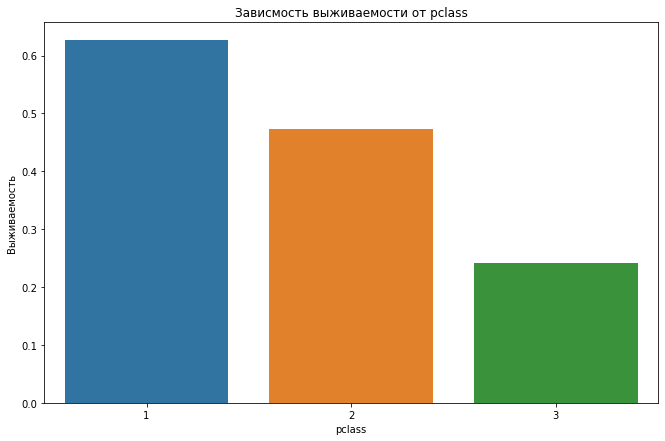

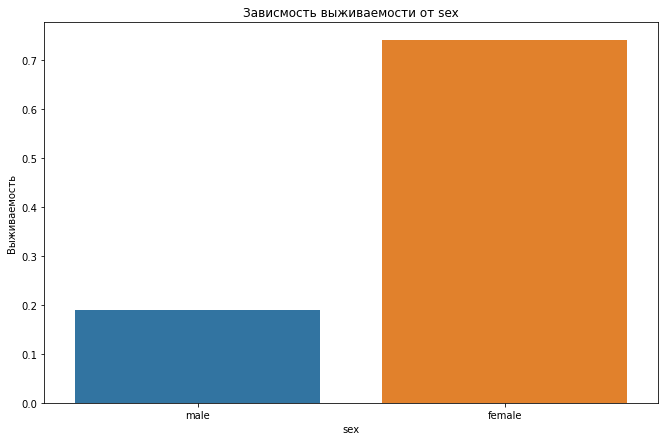

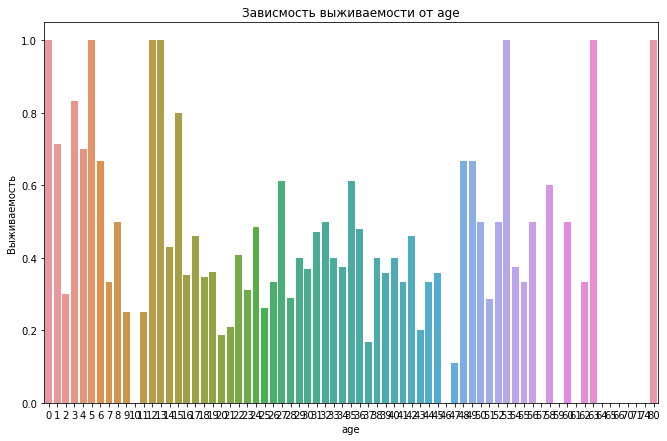

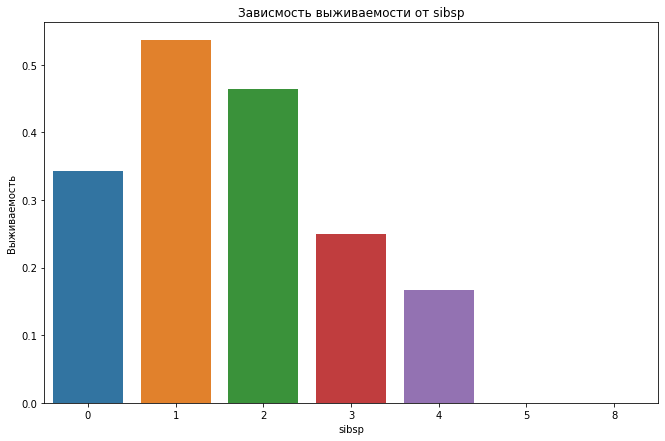

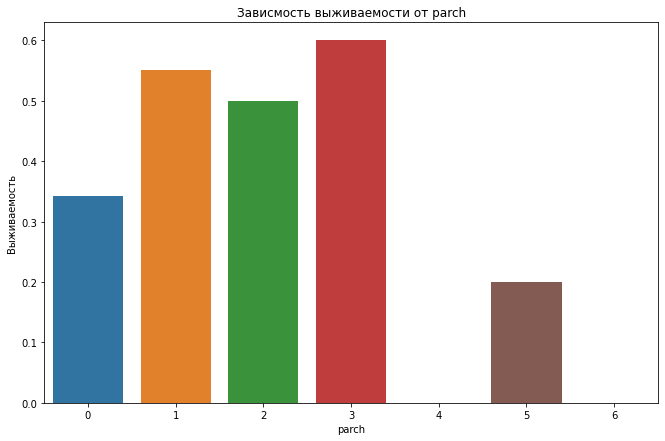

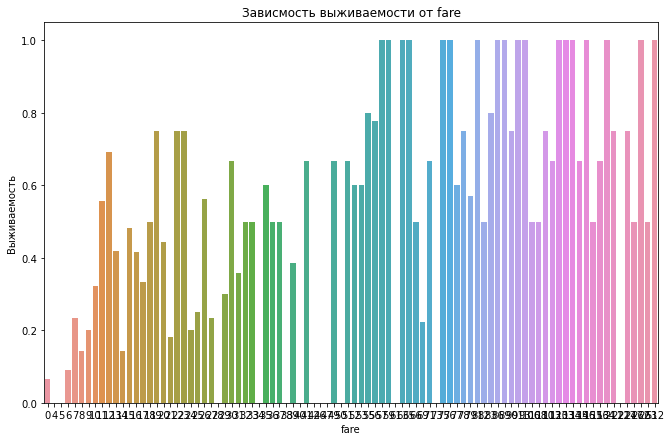

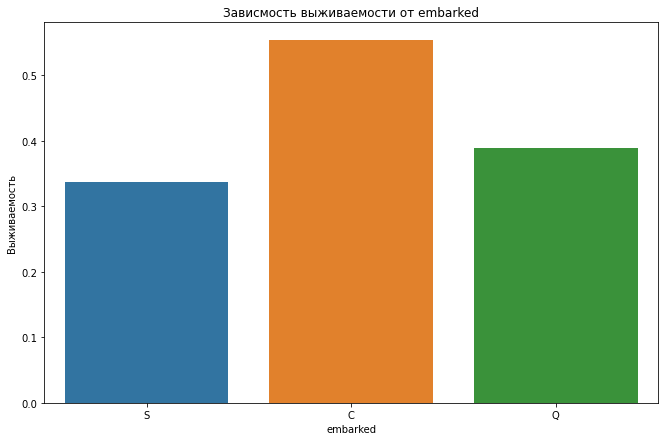

In [21]:
for column in columns_list:
  sns.barplot(x=train[column], y=train['survived'], ci=None)\
    .set(title='Зависмость выживаемости от {}'.format(column), ylabel='Выживаемость')
  plt.show()

Удивительно, но признак, насчет которого мы больше всего сомневались, embarked, имеет определенное влияние на целевой признак. По какой-то причине пассажиры, порт посадки которых был С, имели больше шансов на выживание, чем пассажиры с другим портом посадки. Мы никак не можем это прокомментировать, зато можем принять как факт и не удалять этот признак из выборки. 

Подтвердилось наше предположение, что значительное влияние на факт выживания оказывает пол и возраст пассажира. На графиках четко видно, что женщины выживали в более, чем 70% случаев, в то время как мужчины только в 20%. Возраст тоже влиял достаточно очевидно – в основном спасались дети и немного старики. 

Значительное влияние на выживаемость также оказывал класс билета. Чем выше класс, тем больше шансов выжить.


Также из анализа выше можно сделать вывод, что у нас очень слабо выражены линейные зависимости. Соответственно, можно предположить, что линейные модели (например, логистическая регрессия) будут работать хуже, чем деревянные и тд. 

С зависимостями и корреляциями мы разобрались, теперь перйдем к кодированию признаков. Нам необходимо закодировать признаки sex и embarked. Для этого мы используем метод get_dummies. Мы не используем One hot encoding, потому что у нас нет необходимости отдельно обучать и применять метод. Данных и в тренировочном, и в тестовом датасете содержат одинаковые категории, которые не изменятся впоследствии, поэтому get_dummies нас полностью устраивает. 

In [22]:
train_dummy = pd.get_dummies(train, prefix_sep='_', columns=['embarked', 'sex'], dtype=int)
test_dummy = pd.get_dummies(test, prefix_sep='_', columns=['embarked', 'sex'], dtype=int)

In [23]:
train_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   passengerid  889 non-null    int64
 1   survived     889 non-null    int64
 2   pclass       889 non-null    int64
 3   age          889 non-null    int64
 4   sibsp        889 non-null    int64
 5   parch        889 non-null    int64
 6   fare         889 non-null    int64
 7   embarked_C   889 non-null    int64
 8   embarked_Q   889 non-null    int64
 9   embarked_S   889 non-null    int64
 10  sex_female   889 non-null    int64
 11  sex_male     889 non-null    int64
dtypes: int64(12)
memory usage: 83.5 KB


Нормирование признаков в данном случае нам не нужно, потому что у нас крайне мало линейных зависимостей. Мы не будем использовать линейные модели. А для деревянных моделей не требуется нормирование. 
Балансировку классов мы будем проводить после первичного теста моделей, чтобы посмотреть, есть ли положительное влияние на результат. 
На этом момент можем смело переходить к подготовке данных для моделей. 

## <a id='6'>Обучение моделей</a>

- [Перейти в начало проекта](#1)
- [Перейти к предыдущему блоку](#5)
- [Перейти к следующему блоку](#7)

В этом разделе нам необходимо: 
- Удалить признак passengerid (сохранить его в отдельный series)
- Разделить данные на features и target
- Разделить данные на тренировочную и валидационную выборки 
- Импортировать необходимые модели и протестировать их 
- Покрутить различные параметры моделей для получения наилучшего результата 

Удалим признак passengerid в тренировочном датасете полностью, а в тестовом сохраним его в отдельный series, потому что он нам еще пригодится. 

In [24]:
train_dummy = train_dummy.drop(['passengerid'], axis=1)
train_dummy

,survived,pclass,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male
0,0,3,22,1,0,7,0,0,1,0,1
1,1,1,38,1,0,71,1,0,0,1,0
2,1,3,26,0,0,7,0,0,1,1,0
3,1,1,35,1,0,53,0,0,1,1,0
4,0,3,35,0,0,8,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
884,0,2,27,0,0,13,0,0,1,0,1
885,1,1,19,0,0,30,0,0,1,1,0
886,0,3,28,1,2,23,0,0,1,1,0
887,1,1,26,0,0,30,1,0,0,0,1


In [25]:
passengerid_test = test_dummy['passengerid']
test_dummy = test_dummy.drop(['passengerid'], axis=1)

In [26]:
passengerid_test

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: passengerid, Length: 418, dtype: int64

Разделим данные тренировочной выборки на features (X) и target (y).

In [27]:
X_train = train_dummy.drop(['survived'], axis=1)
y_train = train_dummy['survived']
X_test = test_dummy

Вместо деления на тренировочную и валидационную выборку мы будем пользоваться кросс-валидацией от GridSearchCV. Более того, это поможет в подборе параметров.

Начнем со случайного леса.

In [28]:
param_grid = {'max_depth': range(2, 16, 1), 'n_estimators': range(10, 100, 10)}
gs = GridSearchCV(RandomForestClassifier(random_state=12, class_weight='balanced'), param_grid=param_grid, return_train_score=True, n_jobs=4, scoring='accuracy')

In [29]:
%%time
gs.fit(X_train, y_train)

CPU times: user 516 ms, sys: 96.9 ms, total: 612 ms
Wall time: 10.4 s


GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=12),
             n_jobs=4,
             param_grid={'max_depth': range(2, 16),
                         'n_estimators': range(10, 100, 10)},
             return_train_score=True, scoring='accuracy')

In [30]:
gs.best_params_

{'max_depth': 12, 'n_estimators': 90}

In [31]:
gs.best_score_ #на тестовых данных на кеггле эта модель дала результат 0.75

0.8279502317018981

0.83 - вполне неплохой результат, но можно и лучше. Попробуем CatBoost.

In [32]:
param_grid = {'depth': range(2, 16, 1), 'iterations': range(10, 130, 10)}
gs = GridSearchCV(CatBoostClassifier(random_state=12), param_grid=param_grid, return_train_score=True, n_jobs=4, scoring='accuracy')

In [33]:
%%time
gs.fit(X_train, y_train)

Learning rate set to 0.08914
0:	learn: 0.6589262	total: 57.5ms	remaining: 5.12s
1:	learn: 0.6306657	total: 58.2ms	remaining: 2.56s
2:	learn: 0.6101763	total: 58.5ms	remaining: 1.7s
3:	learn: 0.5912668	total: 58.9ms	remaining: 1.27s
4:	learn: 0.5699902	total: 59.3ms	remaining: 1.01s
5:	learn: 0.5543684	total: 59.7ms	remaining: 835ms
6:	learn: 0.5424165	total: 60ms	remaining: 712ms
7:	learn: 0.5281721	total: 60.4ms	remaining: 619ms
8:	learn: 0.5150550	total: 60.8ms	remaining: 547ms
9:	learn: 0.5039907	total: 61.2ms	remaining: 489ms
10:	learn: 0.4955522	total: 61.6ms	remaining: 443ms
11:	learn: 0.4873625	total: 62ms	remaining: 403ms
12:	learn: 0.4800678	total: 62.3ms	remaining: 369ms
13:	learn: 0.4736354	total: 62.8ms	remaining: 341ms
14:	learn: 0.4667396	total: 63.1ms	remaining: 316ms
15:	learn: 0.4621575	total: 63.6ms	remaining: 294ms
16:	learn: 0.4562351	total: 63.9ms	remaining: 274ms
17:	learn: 0.4517964	total: 64.3ms	remaining: 257ms
18:	learn: 0.4480694	total: 64.7ms	remaining: 242m

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7f8f984eb8e0>,
             n_jobs=4,
             param_grid={'depth': range(2, 16),
                         'iterations': range(10, 130, 10)},
             return_train_score=True, scoring='accuracy')

In [34]:
gs.best_params_

{'depth': 4, 'iterations': 90}

In [35]:
gs.best_score_ #на тестовых данных на кеггле эта модель дала 0.78

0.8268139402018664

Протестируем экстра-деревья. 

In [36]:
param_grid = {'max_depth': range(2, 16, 1), 
              'n_estimators': range(10, 100, 10)}
gs = GridSearchCV(ExtraTreesClassifier(random_state=12), param_grid=param_grid, return_train_score=True, n_jobs=4, scoring='accuracy')

In [37]:
%%time
gs.fit(X_train, y_train)

CPU times: user 467 ms, sys: 30.8 ms, total: 498 ms
Wall time: 8.49 s


GridSearchCV(estimator=ExtraTreesClassifier(random_state=12), n_jobs=4,
             param_grid={'max_depth': range(2, 16),
                         'n_estimators': range(10, 100, 10)},
             return_train_score=True, scoring='accuracy')

In [38]:
gs.best_score_ #на тестовых данных эта модель дала результат в 0.77

0.8245477051990097

In [39]:
gs.best_params_

{'max_depth': 8, 'n_estimators': 80}

## <a id='7'>Итог</a>

- [Перейти в начало проекта](#1)
- [Перейти к предыдущему блоку](#6)

Лучше всех на тренировочных данных себя показала модель CatBoost. Ее мы и будем использовать для предсказания на тестовых данных. 

In [40]:
model = CatBoostClassifier(random_state=12, depth=4, iterations=90)
model.fit(X_train, y_train)
predicted_test = model.predict(X_test)

Learning rate set to 0.08914
0:	learn: 0.6589262	total: 500us	remaining: 44.5ms
1:	learn: 0.6306657	total: 1.08ms	remaining: 47.5ms
2:	learn: 0.6101763	total: 1.49ms	remaining: 43.3ms
3:	learn: 0.5912668	total: 1.97ms	remaining: 42.4ms
4:	learn: 0.5699902	total: 2.35ms	remaining: 40ms
5:	learn: 0.5543684	total: 2.76ms	remaining: 38.7ms
6:	learn: 0.5424165	total: 3.16ms	remaining: 37.5ms
7:	learn: 0.5281721	total: 3.49ms	remaining: 35.8ms
8:	learn: 0.5150550	total: 3.84ms	remaining: 34.6ms
9:	learn: 0.5039907	total: 4.27ms	remaining: 34.2ms
10:	learn: 0.4955522	total: 4.86ms	remaining: 34.9ms
11:	learn: 0.4873625	total: 5.32ms	remaining: 34.6ms
12:	learn: 0.4800678	total: 5.69ms	remaining: 33.7ms
13:	learn: 0.4736354	total: 5.98ms	remaining: 32.5ms
14:	learn: 0.4667396	total: 6.5ms	remaining: 32.5ms
15:	learn: 0.4621575	total: 7.04ms	remaining: 32.6ms
16:	learn: 0.4562351	total: 7.56ms	remaining: 32.5ms
17:	learn: 0.4517964	total: 8.33ms	remaining: 33.3ms
18:	learn: 0.4480694	total: 8.7

In [41]:
predicted_test = pd.DataFrame(predicted_test)
passengerid_test = pd.DataFrame(passengerid_test)

In [42]:
test_result = passengerid_test.join(predicted_test, how='inner')

In [43]:
test_result.columns = gender_sub.columns
test_result

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [44]:
test_result.to_csv('test_result.csv', index=False)

#### На тестовых данных на Kaggle эта модель показала результат 0.78 